In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2, tqdm
%matplotlib inline

from importlib import reload

from utils import saveVideo, show, drawShape
import colorTools as ct, utils

import laneFindingPipeline

In [2]:
undistort = laneFindingPipeline.Undistorter()
undistort.fit()

A Jupyter Widget

In [3]:
import skvideo.io

videoPrefices = ('project', 'challenge', 'harder_challenge')
allFrames = {}
for videoPrefix in videoPrefices:
    fpath = '%s_video.mp4' % videoPrefix
    reader = skvideo.io.FFmpegReader(fpath)
    frames = []
    for f in tqdm.tqdm_notebook(
        reader.nextFrame(), 
        total=reader.inputframenum,
        desc='load %s' % videoPrefix,
    ):
        frames.append(f)
    allFrames[videoPrefix] = frames

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Which frames are problems?

In [4]:
colorFilter = laneFindingPipeline.ColorFilter()
perspective = laneFindingPipeline.PerspectiveTransformer()

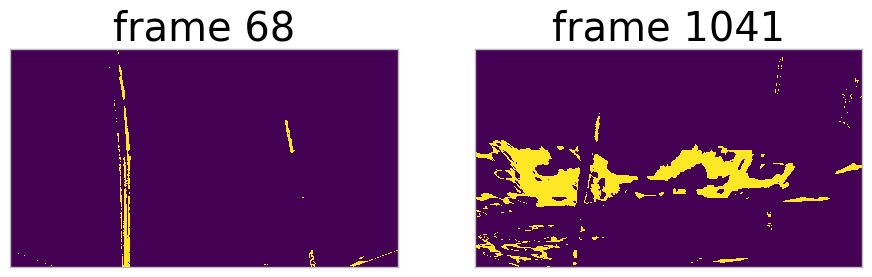

In [6]:
ieasy = 68
easyFrame = allFrames['project'][ieasy]
ihard = 1041
hardFrame = allFrames['project'][ihard]
def get_s(frame, eq=True):
    img = perspective(undistort(frame))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    if eq:
        img = ct.equalizeHist(img)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls[:, :, 2]
method = 'HL[S](eq)'
#utils.show(hardFrame);
fig, (ax, bx) = plt.subplots(ncols=2)
utils.show(get_s(easyFrame) > 250, ax=ax, title='frame %d' % ieasy);
utils.show(get_s(hardFrame) > 254, ax=bx, title='frame %d' % ihard);

In [8]:
countSeekingThreshold = ct.CountSeekingThreshold()
for frame in easyFrame, hardFrame:
    mask, thresh = countSeekingThreshold(get_s(frame))
    print(thresh, '-->', mask.sum())

250 --> 12484
255 --> 0


# Prototype a thresholding pipeline.

In [ ]:
reload(laneFindingPipeline)
reload(ct)

try:
    'project' in vids
except NameError:
    vids = {}
    
colorFilter = laneFindingPipeline.ColorFilter()

for videoPrefix in ('project', 'challenge', 'harder_challenge',):
# for videoPrefix in ('harder_challenge',):
    
    fig, rows = plt.subplots(nrows=5, ncols=5)
    axes = []
    for row in rows: axes.extend(row)
        
    frames = allFrames[videoPrefix]
    lo, hi = dict(
        #project=(980, 1050),
        project=(980, 1000),
        #challenge=(102, 164),
        challenge=(133, 164),
        #harder_challenge=(100, 200),
        harder_challenge=(169, 200),
    )[videoPrefix]
    frameIndices = list(range(len(frames)))[lo:hi]
    
    laneFinder = laneFindingPipeline.LaneFinder(undistort)

    def yieldFrames(blurK=71):
        for i in frameIndices:
            
            # Make a statful image-showing function.
            iaxes = iter(axes)
            color = 'black'
            def show(item, title=None, kind='permissive'):
                if len(set(item.ravel())) == 2 and kind == 'permissive':
                    kind = 'mask'
                import matplotlib.cm
                from matplotlib.colors import LinearSegmentedColormap
                kind = dict(
                    permissive='viridis',
                    restrictive='plasma',
                    mask='binary_r',
                    pton=LinearSegmentedColormap.from_list(
                        'Princeton', [(0,0,0), (232/255, 119/255, 34/255)], N=2
                    )
                ).get(kind, kind)
                cmap = matplotlib.cm.get_cmap(kind)
                ax = iaxes.__next__()
                ax.imshow(item, cmap=cmap)
                ax.set_xticks([]); ax.set_yticks([])
                if title is not None:
                    ax.set_title(title, fontsize=8, color=color)
                    
            # Define sobelclip as a subgraph of the ... computational graph
            # we're assembling.
            def sobelclip(channel):
                # Adaptive thresholding of color.
                tmask, thresh = countSeekingThreshold(channel)

                # Dilated masks of the threshold.
                narrow = ct.dilate(tmask, ksize=10, iterations=5)
                wide = ct.dilate(narrow, ksize=10, iterations=5)
                
                # Restricted Sobel-X
                toSobel = np.copy(channel)
                toSobel[np.logical_not(wide)] = 0
                
                sobel = colorFilter.dilateSobel(toSobel)
                clippedSobel = sobel & narrow
                
                return tmask, thresh, narrow, wide, toSobel, sobel, clippedSobel
            
            # Do basic transforms.
            frame = frames[i]
            warped = perspective(undistort(frame))
            blurred = ct.blur(warped)
            show(frame, 'frame %d' % i)
            show(warped)
            show(blurred, 'blurred')
            
            # Get channels.
            gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
            hls = cv2.cvtColor(blurred, cv2.COLOR_RGB2HLS)
            eq = ct.equalizeHist(blurred)
            l_channel = hls[:, :, 1]
            s_channel = hls[:, :, 2]
            hlseq = cv2.cvtColor(eq, cv2.COLOR_RGB2HLS)
            bseq_channel = ct.blur(hlseq[:, :, 2], blurK)
            lab = cv2.cvtColor(eq, cv2.COLOR_RGB2LAB)
            labaeq_channel = lab[:, :, 1]
            blabbeq_channel = ct.blur(lab[:, :, 2], blurK)
            
            show(gray, 'gray', kind='Greys_r')
            show(eq, 'equalized histogram')
            show(s_channel, r's_channel')
            show(l_channel, r'l_channel')
            show(bseq_channel, 'blur(seq_channel, %d)' % blurK)
            #show(leq_channel, 'leq_channel')
            #show(labaeq_channel, 'labaeq_channel')
            show(blabbeq_channel, 'blur(labbeq_channel, %d)' % blurK)
            show(countSeekingThreshold(bseq_channel)[0], 'blur(seq_channel, %d)' % blurK)
            
            
            # Clipped dilated Sobel on the S channel.
            color = 'green'
            tmask, thresh, narrow, wide, toSobel, sobel, clippedSobel = sobelclip(s_channel)
            show(tmask, r's thresh (>%d, %d px) $\longmapsto$' % (thresh, tmask.sum()))
            show(narrow, 'narrow dilated s thresh $\longmapsto$')
            show(wide, 'wide dilated s thresh $\longmapsto$')
            show(toSobel, 'wide-clipped s_channel $\longmapsto$')
            show(sobel, 'sobel = fxd(wide-clipped s_channel) $\longmapsto$')
            show(clippedSobel, 'clippedSobel = narrow-clipped sobel')

            
            # Adaptive thresholding of brighter color.
            color = 'red'
            labbeqmask, labbeqthresh = countSeekingThreshold(blabbeq_channel)
            labbeqmask = ct.dilate(labbeqmask)
            S = clippedSobel & labbeqmask# & shadowMask
            show(labbeqmask, r'dilate(blur(labbeq) thresh (>%d, %d px)) $\longmapsto$' % (labbeqthresh, labbeqmask.sum()))
            show(S, 'S = clippedSobel & labbeqmask', kind='restrictive')


            # Clipped dilated Sobel on the L channel.
            color = 'blue'
            _, _, _, _, toSobelL, _, clippedSobelL = sobelclip(l_channel)
            show(toSobelL, 'wide-clipped l_channel $\longmapsto\ldots\longmapsto$')
            L = clippedSobelL# & shadowMask
            L = ct.dilate(L)
            show(L, 'L = dilate(fxd(clipped sobel l))', kind='restrictive')
            
            
            # Finally combine strands with OR.
            Y = S | L
            color = 'black'
            show(Y, 'Y = S | L', kind='pton')
            
            
            # Show regression results on these color thresholds.
            laneFinder.update(Y)
            drawn = laneFinder.draw(frame, call=False, showCentroids=False, showCurves=False, showTrapezoid=False)
            show(drawn, 'composite')
            
            
            # Save the combined figure to the video.
            for ax in axes:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(False)
            fig.subplots_adjust(bottom=0, left=0, right=1, top=.95, wspace=.01, hspace=.18)
            yield utils.fig2img(fig)
            for ax in axes: ax.cla()
                
    
    vid = utils.saveVideo(
        yieldFrames(), 'thresholdSearch-%s.mp4' % videoPrefix, 
        total=len(frameIndices), desc=videoPrefix)
    fig.clf()
    vids[videoPrefix] = vid
    

A Jupyter Widget

A rule seems to be emerging--build the filter in layers, with early layers being permissive and later ones being restrictive. A network of layers, you might say. With decision nodes in each layer--almost like "neurons" of some sort.

In [ ]:
# import time
# time.sleep(4)

# vids['project']

# vids['challenge']

# vids['harder_challenge']

# Show result.

In [ ]:
reload(laneFindingPipeline)
laneFinder = laneFindingPipeline.LaneFinder(undistort)
laneFinder.colorFilter.dilate_kernel = colorFilter.dilate_kernel
utils.show(laneFinder.draw(frame, showTrapezoid=True, showLane=True, showCentroids=False, insetBEV=True, showCurves=False));

# fig, ax = plt.subplots(figsize=(9, 16))
# laneFinder.show(frame, axes=[ax]);